In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
deep_dipole_coordinates = (
    [ 300,  750, 1200, 300, 1200, 1750],  # µm
    [ 300, 1000, 1700, 1600, 300, 1000],  # µm
    [-600, -600, -600, -600, -600, -600],  # µm
)
deep_dipole_moments = mg.angles_to_vector(
    inclination=[-90, 90, -90, 90, 90, -90],
    declination=[0, 0, 0, 0, 0, 0],
    amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
)

Now create the dipole model that will be used to generate the data.

In [31]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [1250]]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [500]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-20]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [0]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [0]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [1e-9]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print()

In [32]:
bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 22.2 22.33 22.47 22.6 ... 4.575 4.494 4.414 4.335

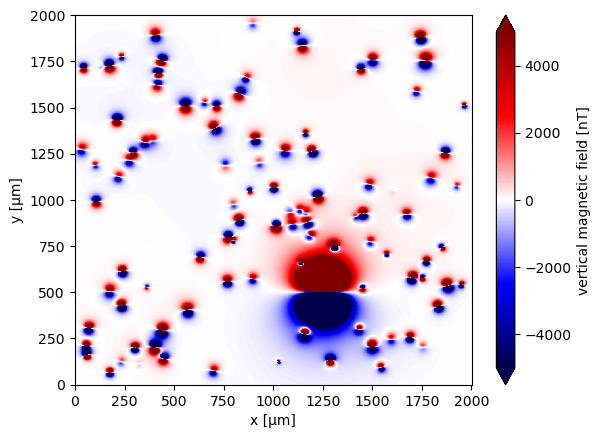

In [33]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [34]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

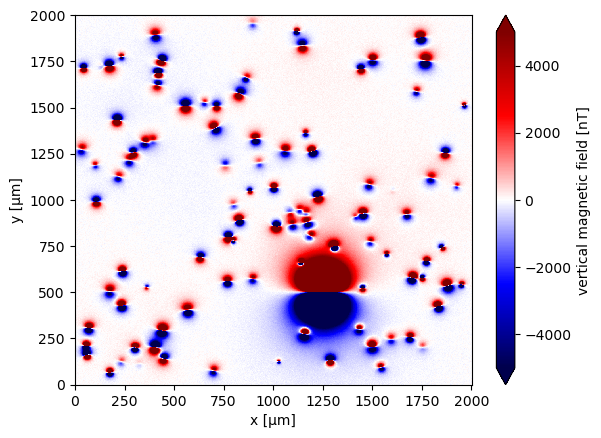

In [35]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Polynomial fitting to suppress high frequency noise
2. Upward continue the data to suppress high frequency noise
3. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
4. Contrast stretch the TGA to highlight weaker sources
5. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Polynomial fitting to suppress low frequency noise

In [36]:
trend = vd.Trend(degree=1).fit((coordinates), data.bz.values)
low_frequency_noise = trend.predict(coordinates).reshape(data.bz.shape)

data = data.assign(low_freq=(['y','x'],low_frequency_noise))
data.low_freq.attrs = {"long_name": "low-frequency noise", "units": "nT"}

residual = data.bz.values - data.low_freq.values
data = data.assign(residual=(['y','x'],residual))
data.residual.attrs = {"long_name": "residual anomaly", "units": "nT"}

data

<xarray.Dataset>
Dimensions:   (y: 1001, x: 1001)
Coordinates:
  * x         (x) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y         (y) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z         (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz        (y, x) float64 37.44 -29.67 59.99 69.63 ... -62.75 -12.46 -25.8
    low_freq  (y, x) float64 -481.0 -480.9 -480.8 -480.8 ... 485.8 485.8 485.9
    residual  (y, x) float64 518.4 451.2 540.8 550.4 ... -548.5 -498.3 -511.7

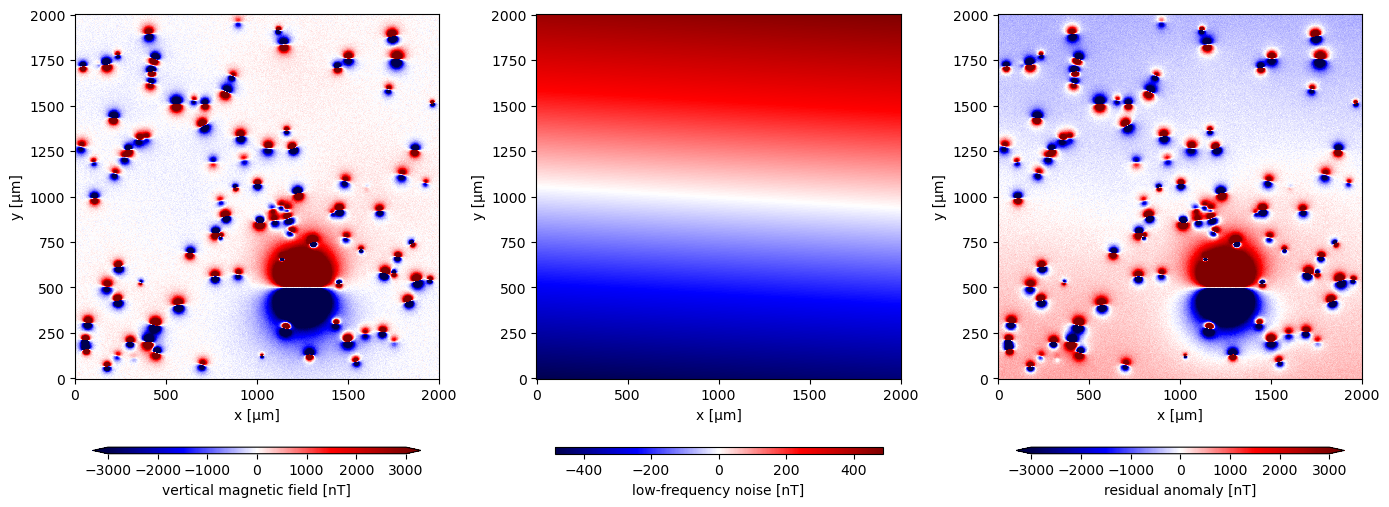

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(14, 14))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.9)
for field, ax in zip(["bz", "low_freq", "residual"], axes.ravel()):
    vmax, vmin = None, None
    if field != "low_freq":
        vmax=+3000
        vmin=-3000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

## 2. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [38]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.residual, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 59.93 67.6 73.55 76.95 ... -76.09 -71.89 -65.48

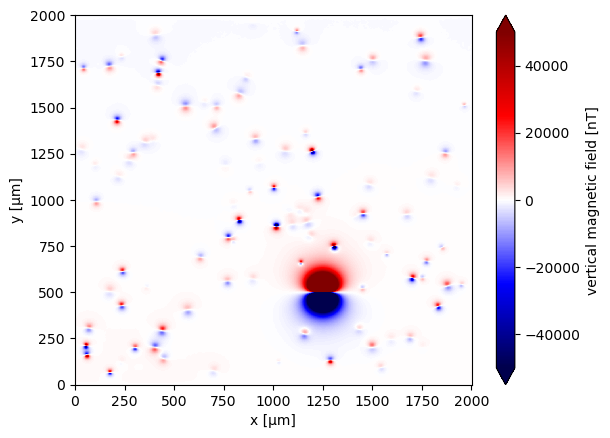

In [39]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 3. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [40]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 59.93 67.6 73.55 76.95 ... -76.09 -71.89 -65.48
    tga      (y, x) float64 52.95 53.14 53.39 53.54 ... 52.6 52.9 52.95 52.74
    x_deriv  (y, x) float64 3.837 3.405 2.337 1.284 ... 0.6945 1.577 2.654 3.205
    y_deriv  (y, x) float64 50.73 50.5 50.46 50.81 ... 50.24 50.35 50.47 50.49
    z_deriv  (y, x) float64 -14.68 -16.18 -17.28 -16.82 ... 16.18 15.81 14.89

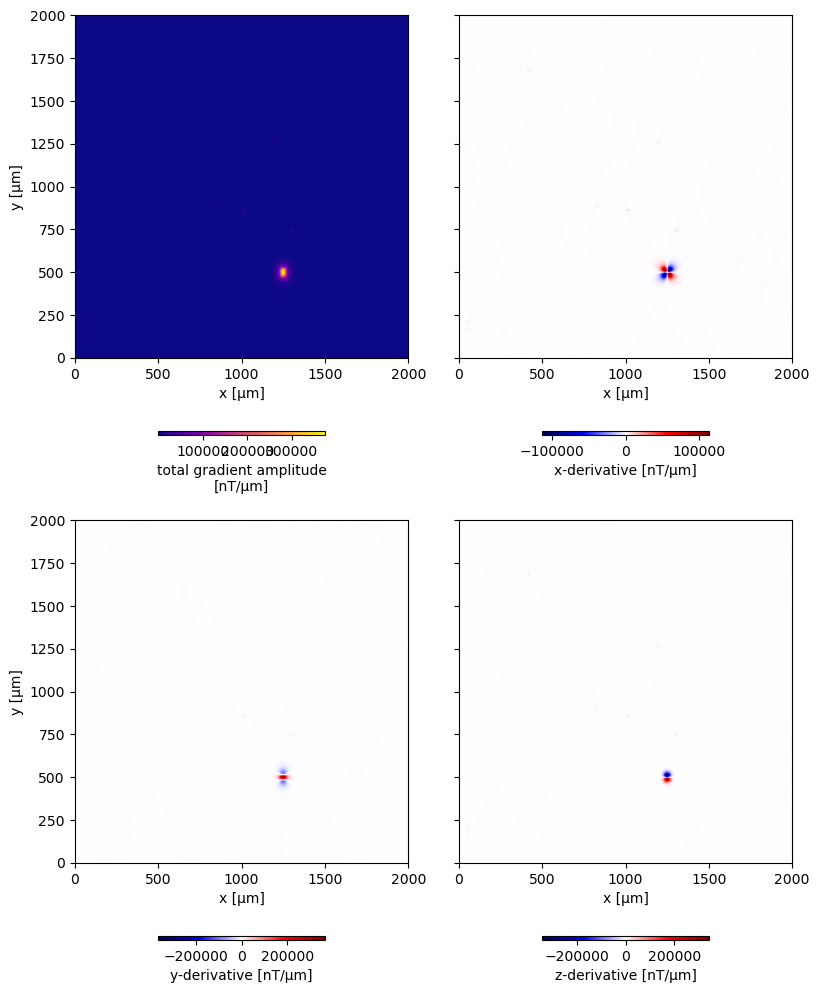

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [42]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

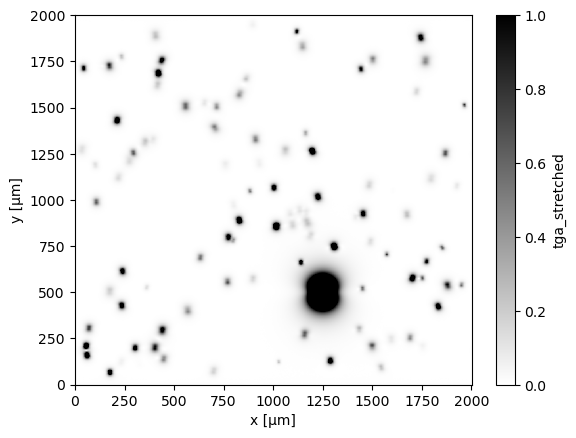

In [43]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 5. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [53]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[10, 200],
    size_increment=1.3,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows


In [54]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  96


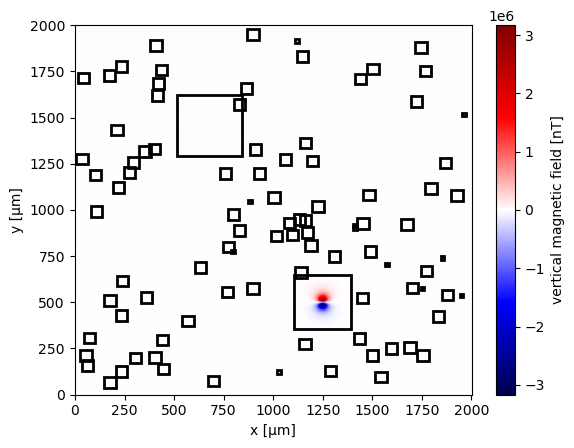

In [55]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [87]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values# - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.9999713717814945 and SNR: 45.44843528231535
R²: 0.9990865007436336 and SNR: 30.6699605362782
R²: 0.9870193332369249 and SNR: 26.579040509905226
R²: 0.9991286875543336 and SNR: 30.713631441215654
R²: 0.9993837018199173 and SNR: 32.216629965702076
R²: 0.9982630158035914 and SNR: 28.767479370318597
R²: 0.999236757355903 and SNR: 33.93570584667757
R²: 0.9990960631220691 and SNR: 31.25746588084002
R²: 0.9994640903576849 and SNR: 34.79250947593183
R²: 0.9993666463866944 and SNR: 32.710651986144114
R²: 0.9993813186709111 and SNR: 34.19191200310839
R²: 0.9991549001258884 and SNR: 30.777510005305132
R²: 0.9878595361030479 and SNR: 20.105735051748724
R²: 0.9954977322085239 and SNR: 28.539137427136623
R²: 0.9929071963500815 and SNR: 21.722427362563963
R²: 0.9987016336785011 and SNR: 32.58137424087839
R²: 0.9983641186391639 and SNR: 32.76317735101286
R²: 0.9987456433073694 and SNR: 33.565797842128305
R²: 0.9980798441974753 and SNR: 28.718139770559524
R²: 0.9955413417959338 and SNR: 30.135296

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [88]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 1.59932917e-01,  3.84058674e-01,  4.79740243e-01,  3.88179242e-01,
        3.66404878e-01,  5.15894705e-01,  2.99762767e-01,  3.52810254e-01,
        2.43582764e-01,  2.67029594e-01,  3.29248161e-01,  3.95669396e-01,
        1.99655153e-01,  4.25270163e-01,  9.31465091e-02,  3.45625271e-01,
        3.36380844e-01,  3.31037284e-01,  2.50960795e-01,  3.70411049e-01,
        4.20911262e-01,  6.59202141e-01,  1.89980938e-02,  9.67453885e-02,
        3.22224314e-01,  1.59084216e+00,  2.27485984e-01,  2.38409767e-01,
        3.60065888e-01,  7.50954569e-01,  2.97897933e-01,  3.50898546e-01,
        8.34924102e-01,  8.89611624e-01,  1.82355224e-01,  3.19410049e+00,
        4.02287792e-01,  2.34301413e-01,  1.99386477e-01, -1.23149625e+00,
        1.91328895e-01,  6.77917492e-01,  1.09664840e+00,  2.70080916e-01,
        7.66170884e-01,  3.67374713e-01,  9.33485293e-01,  1.32580093e-01,
        2.06913986e+00,  7.96084885e-01,  2.36885942e-01,  2.48725336e-01,
        2.33913054e-02, -

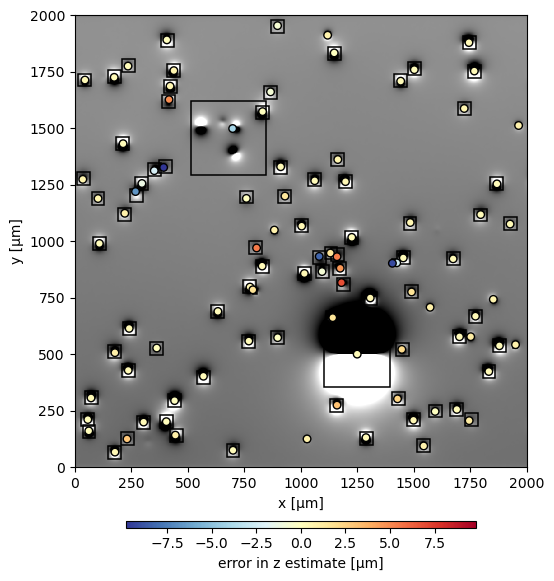

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [90]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(estimated_dipole_moments, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    # print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    # print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    # print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    # print(f"R²   : {r2:.5f} ")
    # print(f"SNR  : {SNR:.5f} ")
    # print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    # print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    # print()

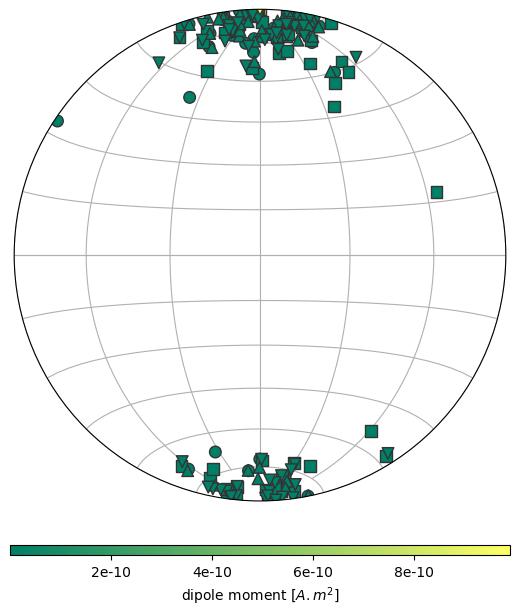

In [91]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [92]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

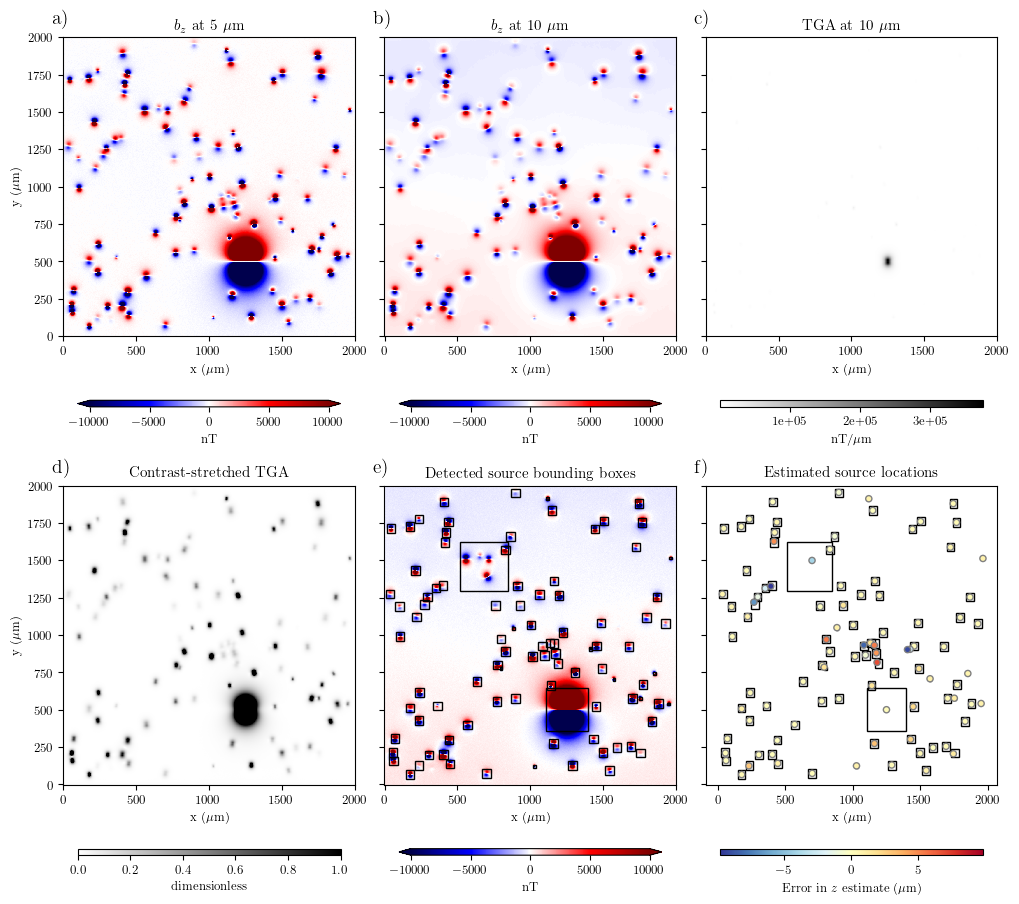

In [93]:
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("auto")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("auto")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.residual.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   

    ax = axes[5]  
    ax.set_aspect("auto")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=z_difference, s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="Error in $z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
    fig.savefig(fig_dir / "complex-synthetic-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

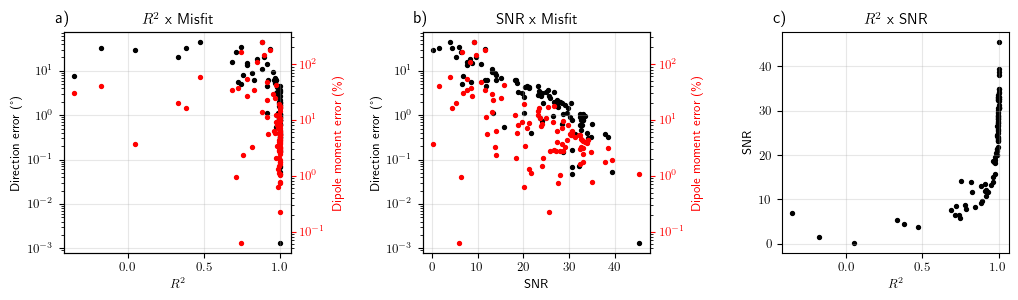

In [94]:
with plt.rc_context(mpl_rc):
    size=8
    fig, axes = plt.subplots(1,3, figsize=(10, 2.8))    

    axes = axes.ravel()
    ax = axes[0]
    ax.scatter(calculated_r2, direction_misfit, color='k', s=size)
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('$R^2$')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_r2, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[1]
    ax.scatter(calculated_SNR, direction_misfit, color='k', s=size, label='direction (°)')
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('SNR')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_SNR, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_xlabel('SNR')
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[2]
    ax.scatter(calculated_r2, calculated_SNR, color='k', s=size)
    ax.set_xlabel('$R^2$')
    ax.set_ylabel('SNR')

    titles = [r'$R^2$ x Misfit', r'SNR x Misfit', r'$R^2$ x SNR']
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_aspect("auto")
        ax.grid(alpha=0.3, which='major')
        ax.set_title(title)




    plt.tight_layout(pad=0, h_pad=0, w_pad=2)
    
    fig.savefig(fig_dir / "complex-synthetic-fitting-test.png", dpi=300, facecolor='w', bbox_inches='tight')

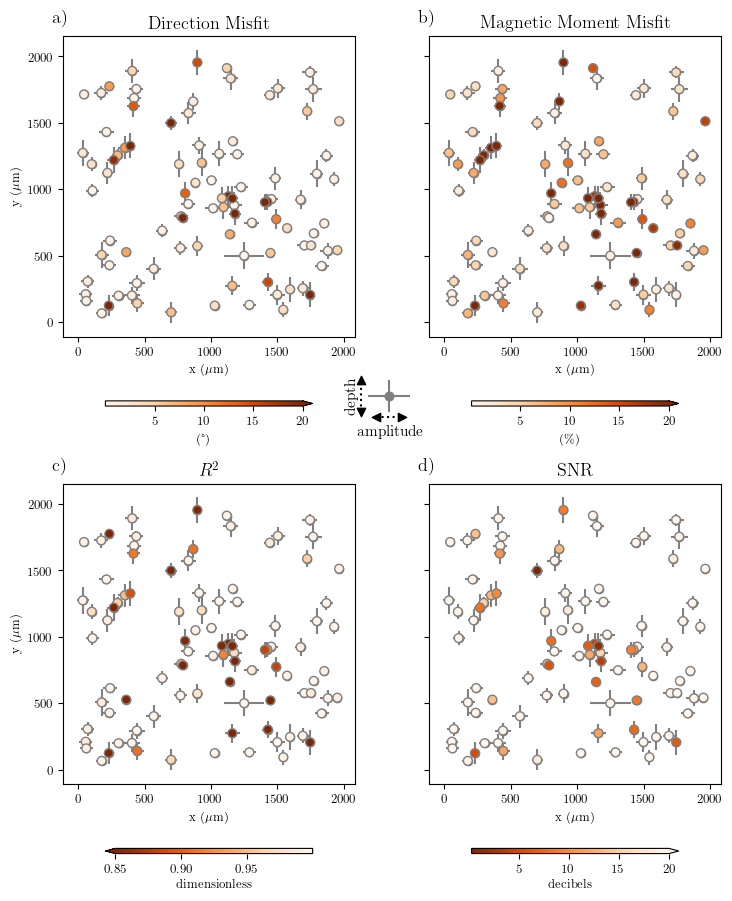

In [95]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(8, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"$R^2$", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    scale = 0.85
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"SNR", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    
    scale = 20
    tmp = ax.scatter(*positions[:2], c=calculated_SNR, s=40, cmap="Oranges_r", edgecolor='gray', vmax=scale)
    fig.colorbar(tmp, ax=ax, label="decibels", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
#         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    
    
    left, bottom, width, height = [0.45, 0.52, 0.09, 0.09]
    ax5 = fig.add_axes([left, bottom, width, height])
    ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
                 fmt='o', zorder=0, color='gray')
    ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
    ax5.set_ylim(-1.0, 1.5)
    ax5.set_xlim(-0.6, 1.1)

    ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
    ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
    ax5.scatter(-0.15, -0.0, marker='v', color='k')
    ax5.scatter(-0.15, 1.0, marker='^', color='k')

    ax5.scatter(0.2,-0.15, marker='<', color='k')
    ax5.scatter(0.8,-0.15, marker='>', color='k')

    ax5.text(-0.25, -0.7, 'amplitude', color='k', fontsize=11)
    ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

    ax5.set_title('', loc='left')
    # Eliminate upper and right axes
    ax5.spines['right'].set_color('none')
    ax5.spines['top'].set_color('none')
    ax5.spines['bottom'].set_color('none')
    ax5.spines['left'].set_color('none')
    ax5.xaxis.set_ticks([])
    ax5.yaxis.set_ticks([])
    
    fig.savefig(fig_dir / "complex-synthetic-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()


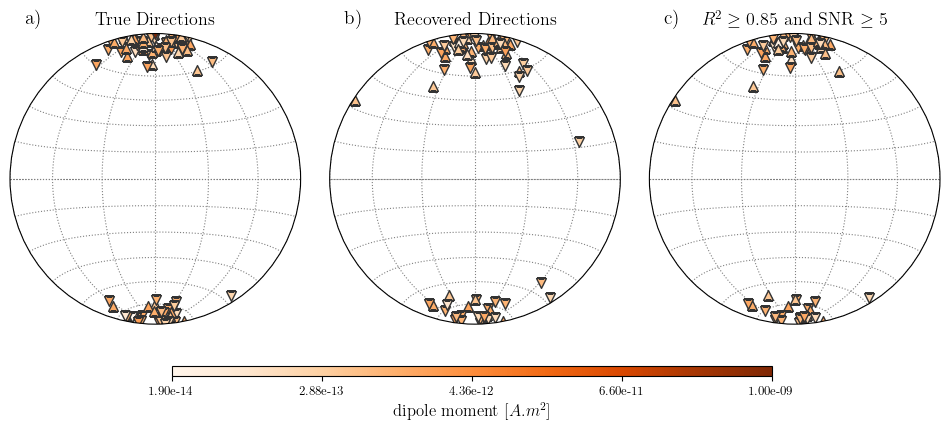

In [96]:
with plt.rc_context(mpl_rc):
    fig, axes = mplstereonet.subplots(1, 3, figsize=(12, 5))

    estimated = mg.vector_to_angles(estimated_dipole_moments)
    true = mg.vector_to_angles(dipole_moments)
    scatter_args = dict(
        vmin=np.min([np.log10(np.min(estimated[2])), np.log10(np.min(true[2]))]),
        vmax=np.max([np.log10(np.max(estimated[2])), np.log10(np.max(true[2]))]),
        cmap="Oranges",
        edgecolors="#333333",
        linewidths=1,
        s=50,
        zorder=2,
    )

    
    ticks=np.linspace( np.min([np.log10(np.min(estimated[2])), np.log10(np.min(true[2]))]),
                       np.max([np.log10(np.max(estimated[2])), np.log10(np.max(true[2]))]), 5)
    
    ax = axes[0]
    for i in range(len(dipole_moments)):
        true = mg.vector_to_angles(dipole_moments[i])
        pos_inc = true[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
            c=np.log10(true[2][pos_inc]),
            marker="^",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
            c=np.log10(true[2][~pos_inc]),
            marker="v",
            **scatter_args,
        )

    ax = axes[1]       
    for i in range(len(estimated_dipole_moments)):
        estimated = mg.vector_to_angles(estimated_dipole_moments[i])
        pos_inc = estimated[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
            c=np.log10(estimated[2][pos_inc]),
            marker="^",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
            c=np.log10(estimated[2][~pos_inc]),
            marker="v",
            **scatter_args,
        )

    ax = axes[2]
    count_r2 = 0         
    for i in range(len(calculated_r2)):
        if calculated_r2[i] >= 0.85 and calculated_SNR[i] >= 5:
#         if calculated_SNR[i] >= 20:
            count_r2 += 1
            estimated = mg.vector_to_angles(estimated_dipole_moments[i])
            pos_inc = estimated[0] > 0
            tmp = ax.scatter(
                *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
                c=np.log10(estimated[2][pos_inc]),
                marker="^",
                **scatter_args,
            )
            tmp = ax.scatter(
                *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
                c=np.log10(estimated[2][~pos_inc]),
                marker="v",
                **scatter_args,
            )

    tick_labels = []
    for i in (ticks):
        tick_labels.append("{:.2e}".format(10**i))


    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.26, 0.10, 0.5, 0.02]), 
        orientation="horizontal", 
        format="%.2e",
        ticks = ticks)
    clb.set_label(label="dipole moment [$A.m^2$]", fontsize=12)
    clb.set_ticklabels(tick_labels)

#     fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.3, 0.1, 0.4, 0.02]), 
#         orientation="horizontal",
#         format="%.0e"
#     ).set_label(label="dipole moment [$A.m^2$]", size=12)

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_azimuth_ticks([])
        ax.grid(linestyle=':', color='gray')
        ax.set_title(title, fontsize=13)
    fig.subplots_adjust(wspace=0.1)
    # plt.tight_layout(pad=0, h_pad=0, w_pad=0.7)
    
    fig.savefig(fig_dir / "complex-synthetic-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()


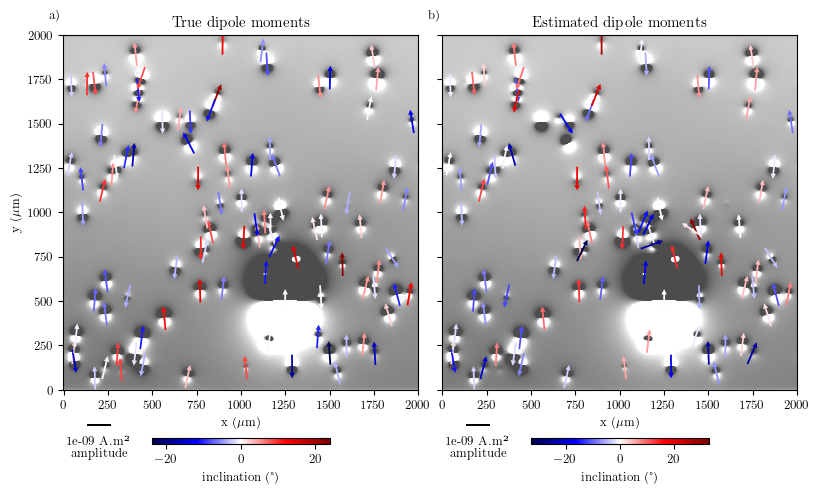

In [97]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    
    for ax in axes:
        scale = 1000
        data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False, add_labels=False, alpha=0.7)
        ax.set_aspect("equal")
        
    cbar_kwargs = dict(orientation="horizontal", aspect=30, pad=0.1, shrink=0.5, label="inclination (°)")
    
    ax = axes[0]
    inc, amp = mg.plot_dipole_moment(dipole_coordinates, dipole_moments, ax=ax, add_colorbar=False)
    plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_title("True dipole moments")
    
    ax = axes[1]
    inc, amp = mg.plot_dipole_moment(positions, estimated_dipole_moments, ax=ax, add_colorbar=False)
    plt.colorbar(inc, ax=ax, **cbar_kwargs)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_title("Estimated dipole moments")
    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    fig.savefig(fig_dir / "complex-synthetic-dipole-moments.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

In [ ]:
bz_predito = mg.dipole_bz([coordinates[0], coordinates[1], data.z], positions, estimated_dipole_moments)

residuo = data.bz.values - bz_predito

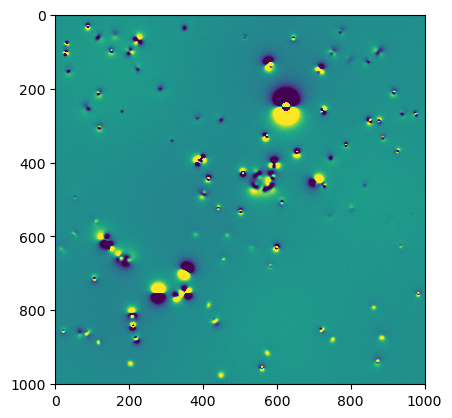

In [ ]:
plt.imshow(residuo, vmax=1000, vmin=-1000)